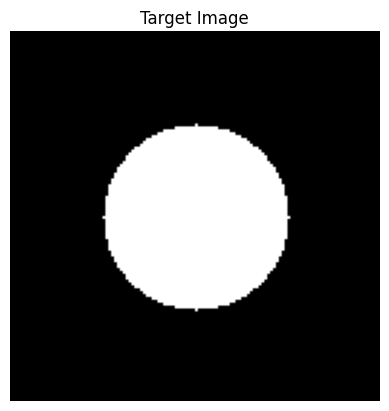

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/root/.local/lib/python3.8/site-packages/stable_baselines3/common/buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 39.33GB > 18.53GB
  warnings.warn(


Step: 3000, Current Reward: -0.00
PSNR: 0.00, SSIM: -0.0000


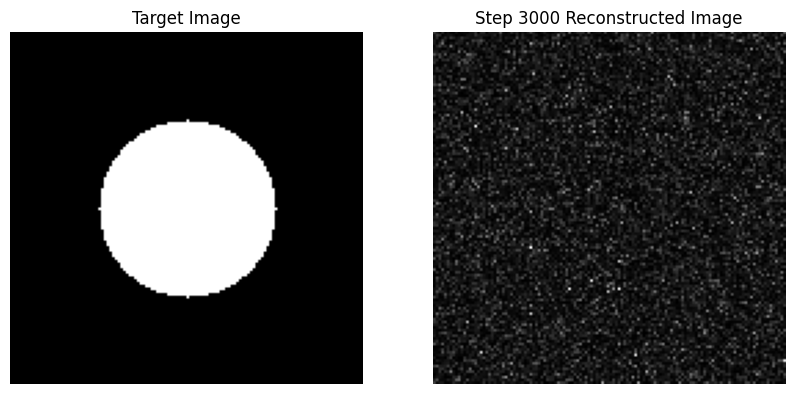

Step: 6000, Current Reward: -0.00
PSNR: 0.00, SSIM: -0.0000


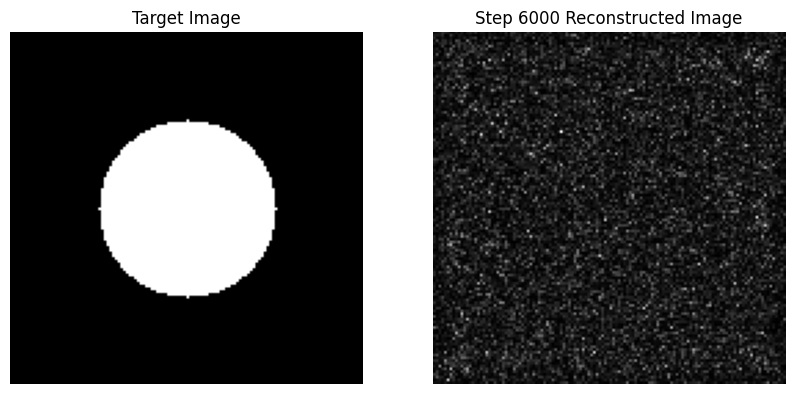

Step: 9000, Current Reward: -0.00
PSNR: 0.00, SSIM: -0.0000


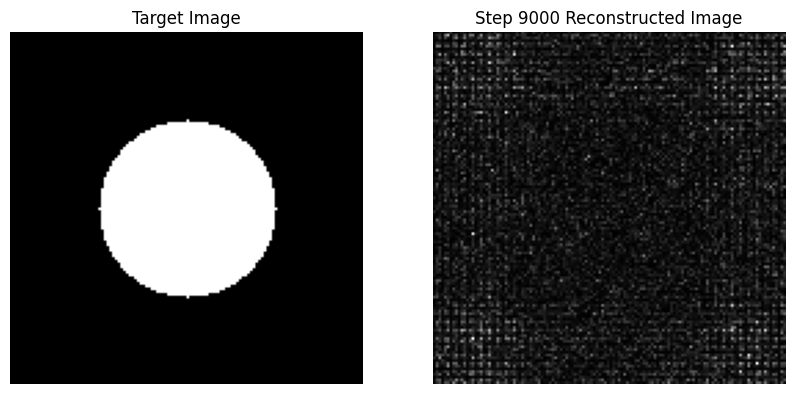

Step: 12000, Current Reward: 0.00
PSNR: 0.00, SSIM: 0.0000


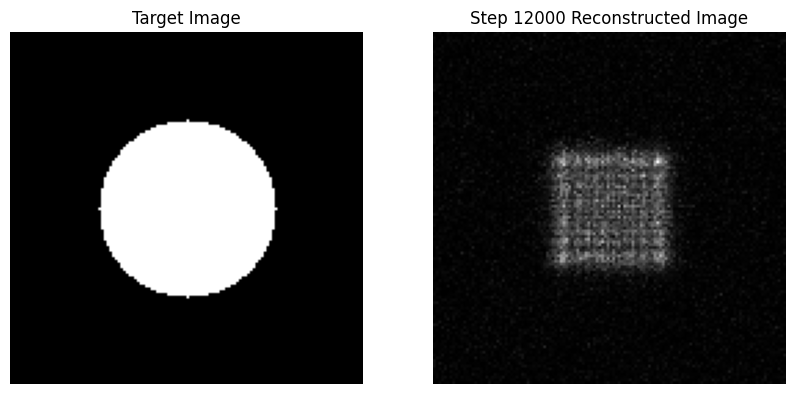

Step: 15000, Current Reward: 0.00
PSNR: 0.00, SSIM: 0.0000


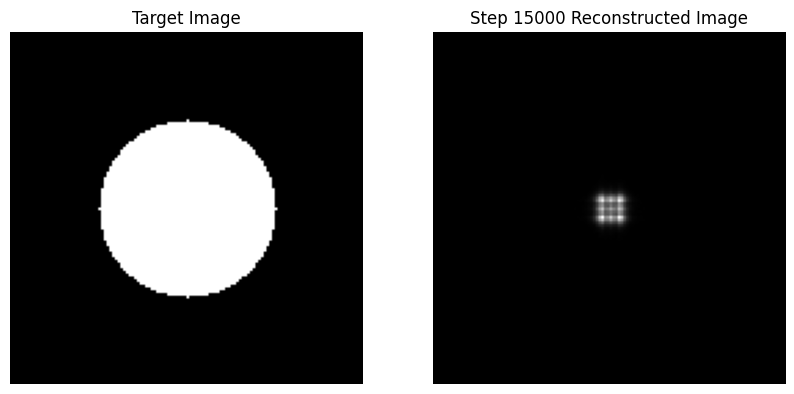

Step: 18000, Current Reward: 0.00
PSNR: 0.00, SSIM: 0.0000


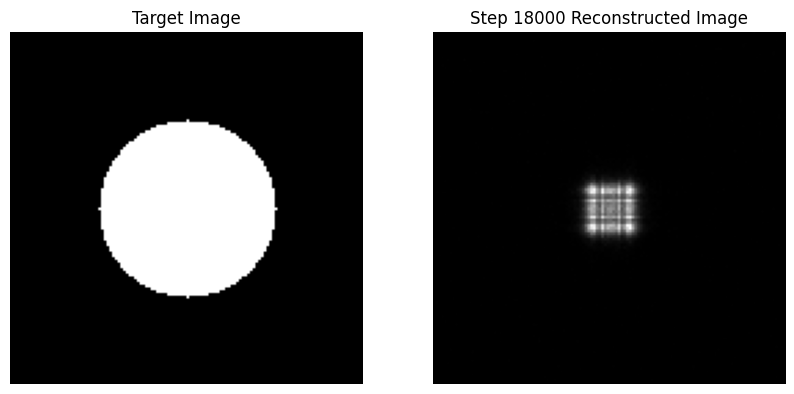

Step: 21000, Current Reward: 0.00
PSNR: 0.00, SSIM: 0.0000


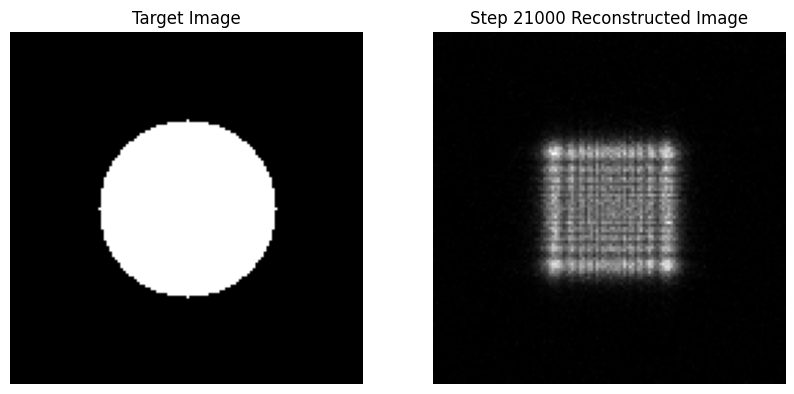


KeyboardInterrupt



In [3]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
import cv2
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from datetime import datetime
from skimage.metrics import structural_similarity as ssim


def calculate_psnr(target, reconstructed):
    """
    PSNR 계산 함수
    :param target: 목표 이미지 (정규화된 값이어야 함)
    :param reconstructed: 재구성된 이미지 (정규화된 값이어야 함)
    :return: PSNR 값
    """
    mse = np.mean((target - reconstructed) ** 2)
    if mse == 0:
        return 100  # 완벽히 일치할 경우 최대값 반환
    max_pixel_value = 1.0  # 정규화된 이미지이므로 최대 픽셀 값은 1
    psnr = 10 * np.log10(max_pixel_value ** 2 / mse)
    return max(psnr, 0)  # 음수일 경우 0으로 설정


class CGHEnv(gym.Env):
    def __init__(self, target_image, grid_size):
        """
        CGH 환경 초기화
        :param target_image: 목표 이미지 (정규화된 흑백 이미지)
        :param grid_size: 위상 패턴의 격자 크기
        """
        super(CGHEnv, self).__init__()
        self.target_image = target_image
        self.grid_size = grid_size

        # 행동 및 상태 공간 정의 (위상 격자와 물리적 매개변수를 하나의 Box로 병합)
        self.action_space = spaces.Box(
            low=np.concatenate([-np.pi * np.ones(grid_size * grid_size), np.array([400e-9, 0.05, 5e-6])]),
            high=np.concatenate([np.pi * np.ones(grid_size * grid_size), np.array([700e-9, 0.2, 20e-6])]),
            dtype=np.float32,
        )
        self.observation_space = self.action_space

        # 초기 상태 정의
        self.state = None

    def reset(self, seed=None, options=None):
        """
        환경 초기화
        """
        super().reset(seed=seed)
        np.random.seed(seed)

        # 위상 패턴 및 물리적 매개변수 초기화
        phase_pattern = np.random.uniform(-np.pi, np.pi, (self.grid_size, self.grid_size))
        physical_params = np.random.uniform(
            [400e-9, 0.05, 5e-6],  # 파장, 거리, 픽셀 크기 최소값
            [700e-9, 0.2, 20e-6],  # 파장, 거리, 픽셀 크기 최대값
        )

        # 상태를 하나의 벡터로 병합
        self.state = np.concatenate([phase_pattern.flatten(), physical_params])
        return self.state, {}

    def step(self, action):
        """
        환경의 한 스텝 진행
        """
        # 위상과 물리적 매개변수 분리
        phase_pattern = action[:-3].reshape(self.grid_size, self.grid_size)
        wavelength, distance, pixel_size = action[-3:]

        # 위상과 물리적 매개변수 업데이트
        self.state = action

        # 홀로그램 생성
        reconstructed_image = self.generate_hologram(phase_pattern, wavelength, distance, pixel_size)

        # PSNR 계산
        psnr = calculate_psnr(self.target_image, reconstructed_image)

        # SSIM 계산
        ssim_value = ssim(self.target_image, reconstructed_image, data_range=1.0)

        # SSIM 임계값
        ssim_threshold = 0.7  # SSIM이 이 값 이상이면 PSNR을 최적화

        if ssim_value < ssim_threshold:
            # 학습 초기 단계: SSIM만 보상으로 사용
            reward = ssim_value * 100
        else:
            # SSIM 임계값 이후: PSNR만 보상으로 사용
            reward = psnr

        terminated = False
        truncated = False
        info = {"PSNR": psnr, "SSIM": ssim_value}

        return self.state, reward, terminated, truncated, info

    def generate_hologram(self, phase_pattern, wavelength, distance, pixel_size):
        """
        프레넬 근사를 사용한 홀로그램 생성
        """
        k = 2 * np.pi / wavelength  # 파수
        x = np.linspace(-self.grid_size // 2, self.grid_size // 2, self.grid_size) * pixel_size
        y = np.linspace(-self.grid_size // 2, self.grid_size // 2, self.grid_size) * pixel_size
        X, Y = np.meshgrid(x, y)

        # 프레넬 전달 함수
        fresnel_transfer_function = np.exp(1j * k / (2 * distance) * (X**2 + Y**2))

        # 복소수 위상 패턴 생성
        complex_field = np.exp(1j * phase_pattern)

        # FFT 기반 프레넬 근사
        hologram = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(complex_field * fresnel_transfer_function)))
        return np.abs(hologram) ** 2  # 강도 패턴 반환


def generate_simple_target(grid_size):
    """
    단순한 테스트용 타겟 이미지 생성
    """
    image = np.zeros((grid_size, grid_size), dtype=np.uint8)
    cv2.circle(image, (grid_size // 2, grid_size // 2), grid_size // 4, 255, -1)
    return image / 255.0


class CustomCallback(BaseCallback):
    """
    학습 중간에 진행 상황을 출력하는 콜백
    """
    def __init__(self, env, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.env = env

    def _on_step(self) -> bool:
        if self.n_calls % 3000 == 0:
            phase_pattern = self.env.state[:-3].reshape(self.env.grid_size, self.env.grid_size)
            params = self.env.state[-3:]
            reconstructed_image = self.env.generate_hologram(phase_pattern, *params)

            # PSNR과 SSIM 계산
            psnr = calculate_psnr(self.env.target_image, reconstructed_image)
            ssim_value = ssim(self.env.target_image, reconstructed_image, data_range=1.0)

            # 진행 상황 출력
            print(f"Step: {self.n_calls}, Current Reward: {self.locals['rewards'][-1]:.2f}")
            print(f"PSNR: {psnr:.2f}, SSIM: {ssim_value:.4f}")

            # 목표 이미지와 재구성 이미지 시각화
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(self.env.target_image, cmap='gray')
            plt.title("Target Image")
            plt.axis("off")
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_image, cmap='gray')
            plt.title(f"Step {self.n_calls} Reconstructed Image")
            plt.axis("off")
            plt.show()
        return True


def train_and_save_model(env, timesteps):
    """
    SAC 알고리즘으로 모델 학습 후 저장
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = f"cgh_sac_model_{timestamp}.zip"

    callback = CustomCallback(env)
    model = SAC("MlpPolicy", env, buffer_size=200000, learning_starts=5000, verbose=1)
    model.learn(total_timesteps=timesteps, callback=callback)
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    return model, model_save_path


def evaluate_and_save_images(env, model, steps):
    """
    학습된 모델 평가 및 재구성된 이미지 저장
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_image_path = f"reconstructed_image_{timestamp}.png"

    obs, _ = env.reset()
    for _ in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

    phase_pattern = obs[:-3].reshape(env.grid_size, self.env.grid_size)
    params = obs[-3:]

    reconstructed_image = env.generate_hologram(phase_pattern, *params)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(env.target_image, cmap='gray')
    plt.title("Target Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title("Reconstructed Hologram")
    plt.axis("off")
    plt.savefig(output_image_path)
    plt.show()
    print(f"Reconstructed image saved to {output_image_path}")


if __name__ == "__main__":
    grid_size = 128
    timesteps = 500000

    target_image = generate_simple_target(grid_size)
    plt.figure()
    plt.imshow(target_image, cmap='gray')
    plt.title("Target Image")
    plt.axis('off')
    plt.show()

    env = CGHEnv(target_image, grid_size)
    model, model_save_path = train_and_save_model(env, timesteps)
    evaluate_and_save_images(env, model, steps=100)
